In [1]:
#Manual implementation of  Single hidden layer mlp with two hidden neurons and one output neuron
from utils.engine import Value
from utils.draw_graph import display_graph

x1 = Value(2.0, label = 'x1')
x2 = Value(3.0, label = 'x2')

w11 = Value(0.4, label='w11')
w21 = Value(0.2, label = 'w21')

b1 = Value(0.01, label = 'b1')

v1 = x1*w11; v1.label = 'x1w11'
v2 = x2*w21; v2.label = 'x2w21'

#Hidden layer
h1 = v1 + v2; h1.label = 'x1w11+x2w21'
n = h1 + b1; n.label = 'x1w11+x2w21+b1'

#Output
op = n.tanh(); op.label = 'op'

In [3]:
op.backward()

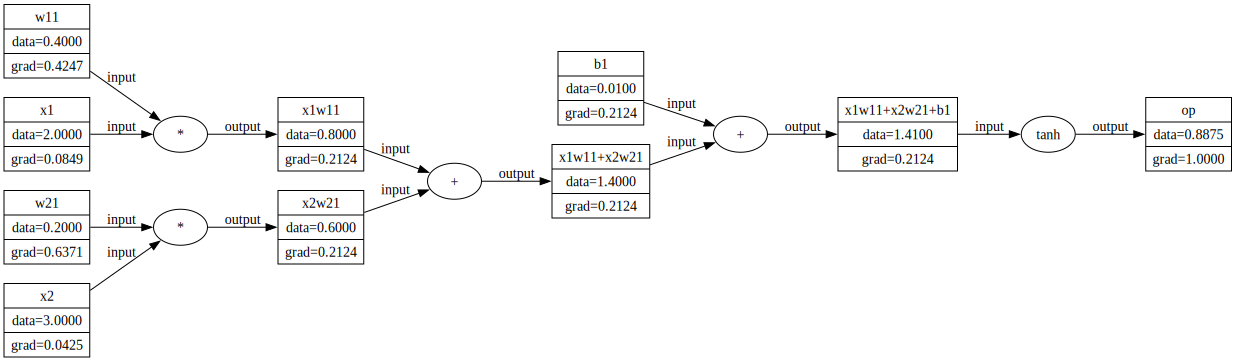

In [4]:
display_graph(op)

In [ ]:
#pytorchifying the code
import torch 

x1 = torch.tensor([2.0], dtype= torch.float64, requires_grad = True)
x2 = torch.tensor([3.0], dtype=torch.float64, requires_grad = True)

w11 = torch.tensor([0.4], dtype = torch.float64, requires_grad=True)
w21 = torch.tensor([0.2], dtype = torch.float64, requires_grad = True)

b1 = torch.tensor([0.01], dtype = torch.float64, requires_grad=True)

h1 = torch.dot(torch.tensor([x1, x2], dtype=torch.float64), torch.tensor([w11, w21], dtype=torch.float64)) + b1
h1.retain_grad()
o1 = torch.tanh(h1)
o1.retain_grad()

o1.backward()
print(f"h1 grad:{h1.grad.item():0.04f}, o1.grad:{o1.grad.item():0.04f}")


h1 grad:0.2124, o1.grad:1.0000


/Users/srini_x62/Dropbox/Mac/Documents/github_repos/nn_zero_to_hero/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [8]:
import random
#REIMPLEMENTING ANDREJ'S VERSION USING SEPARATE CLASSES FOR NEURONS AND LAYERS.

class Neuron:
    def __init__(self, nin:int):
        self.w = [Value(random.uniform(0,1)) for _ in range(nin)]
        self.b = Value(random.uniform(0,1))

    def __call__(self, inp:list[Value])->Value:
        res = sum([w*x for w,x in zip(self.w,inp)], self.b)
        out = res.tanh()
        return out

class Layer:
    def __init__(self, nin:int, nout:int)->None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.outs:list[Value] = []
    
    def __call__(self, inp:list[Value])->list[Value]:
        for n in self.neurons:
            self.outs.append(n(inp))
        return self.outs

class MLP:
    def __init__(self, n_layers:list[int])->None:
        self.n_layers =  n_layers
        self.inp = []
        self.layers = []
    
    def create_all_layers(self, inp:list[int])->None:
        self.inp = [Value(x) for x in inp]
        self.n_layers =[len(inp)] + self.n_layers
        for i, nout in enumerate(self.n_layers[1:]):
            self.layers.append(Layer(self.n_layers[i], nout))

    def __call__(self, inp:list[int])->Value:
        if not self.layers:
            self.create_all_layers(inp)
        input_vec = inp
        for layer in self.layers:
            input_vec = layer(input_vec)
        return input_vec[0] if len(input_vec)==1 else input_vec

In [9]:
#My implementation of MLP
from utils.mlp import MLP

mlp = MLP([2,2,1])
#forward pass
mlp([1,2,3])

Value(data=0.8156, label=n02)

In [ ]:
#Validate child nodes
x=0
def trace(node):
    global x
    if not node._children:
        return None
    print(f"recursion :{x}")
    x+=1
    for child in node._children:
        print(node.label , child)
        trace(child)
trace(mlp.out)

In [11]:
mlp.out.backward()

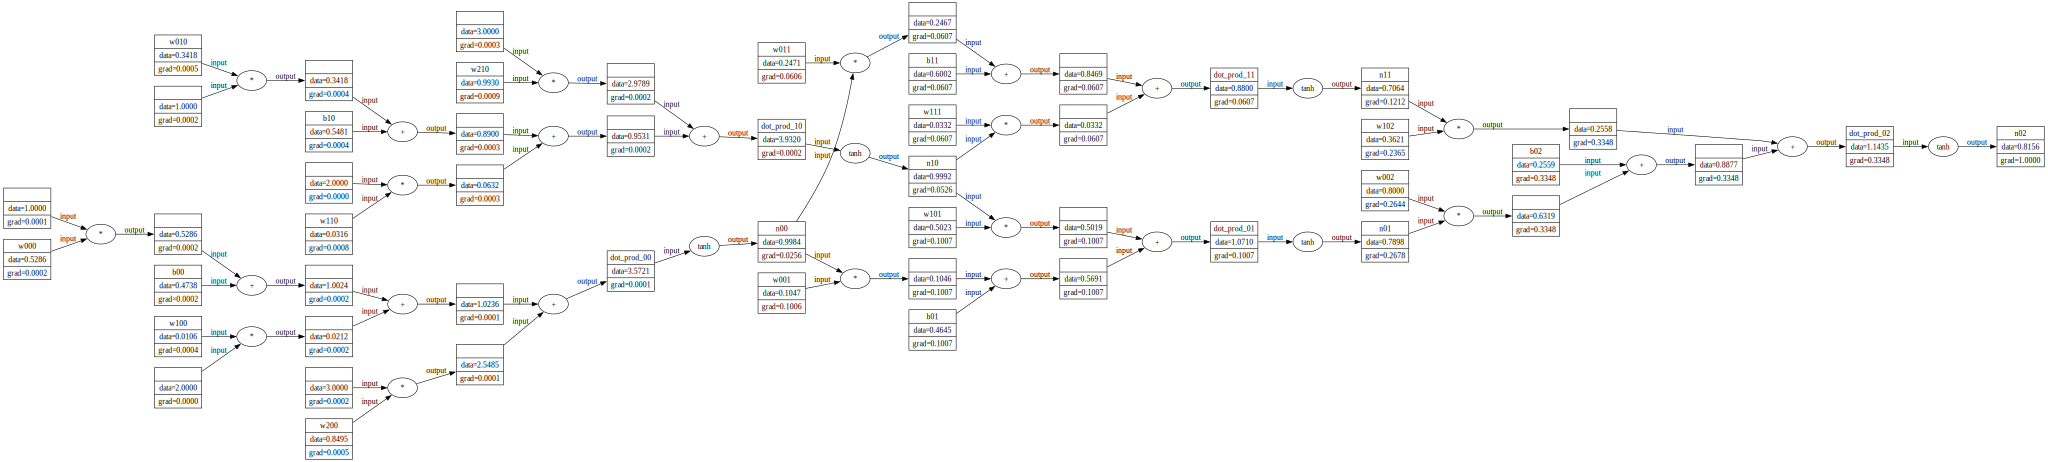

In [12]:
display_graph(mlp.out)

In [13]:
#Creating a dataset
import json
from pathlib import Path
with open(Path(r"./sample_dataset.json"),'r') as f:
    dataset  = json.load(f)

In [14]:
loss = sum((mlp(inp)-pred)**2 for inp, pred in zip(*dataset.values())); loss.label = 'loss'
loss


Value(data=6.6271, label=loss)

In [15]:
from utils.gradient_descent import gradient_descent
mlp = gradient_descent(mlp, dataset)

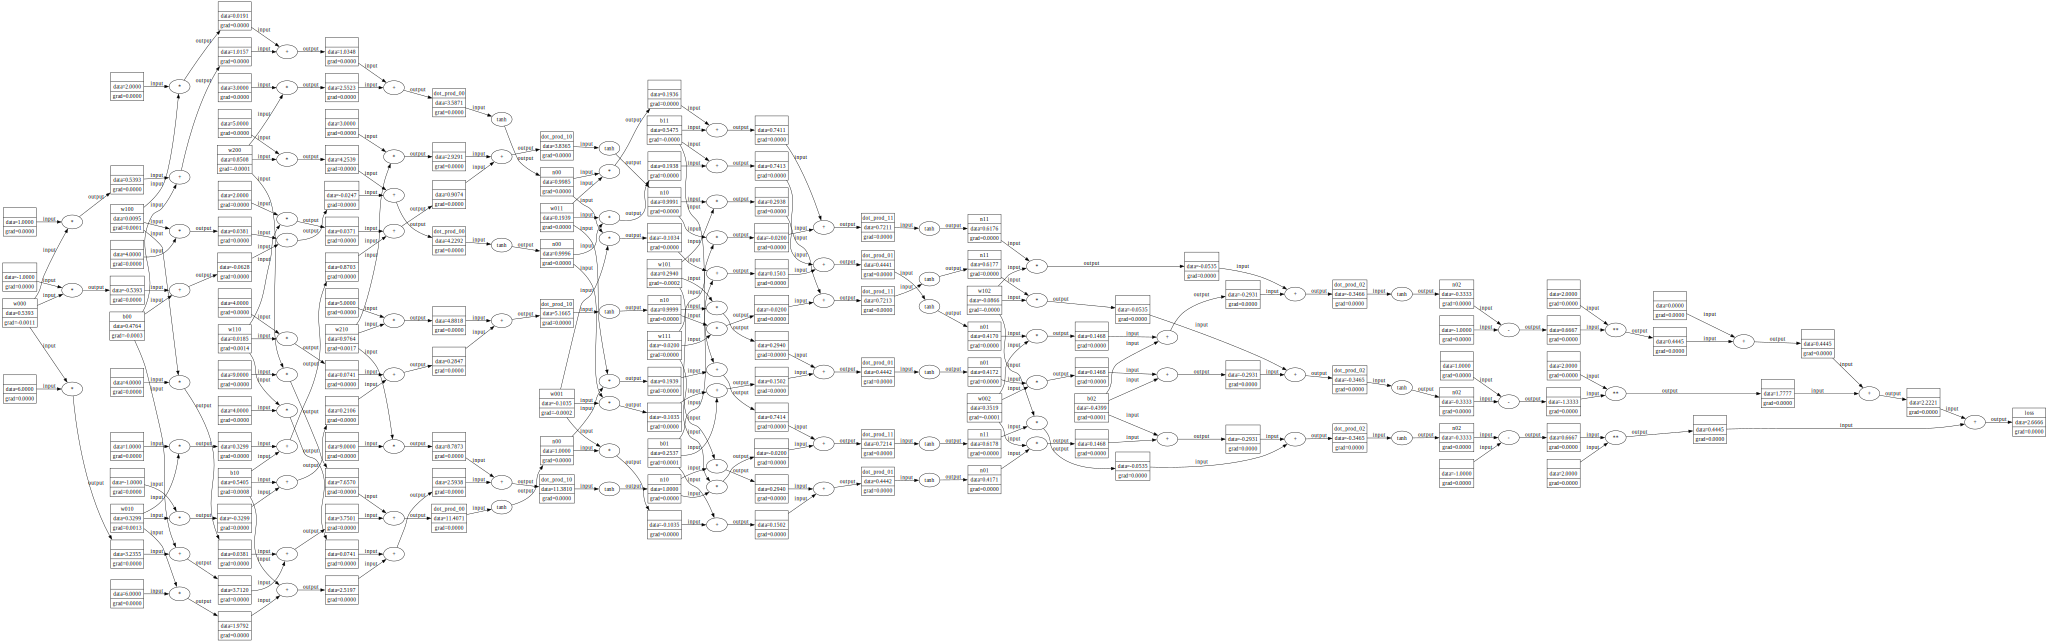

In [18]:
loss = sum((mlp(inp)-pred)**2 for inp, pred in zip(*dataset.values())); loss.label = 'loss'
display_graph(loss)